In [1]:
import torch
import torchattacks
import os
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms, models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# JPEG Compression Functions
def jpeg_compress_np(image, quality):
    """Compress a NumPy image using JPEG at the given quality."""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy().transpose(1, 2, 0)
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
    
    # OpenCV expects BGR
    if image.shape[2] == 3:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        image_bgr = image
        
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)]
    success, encimg = cv2.imencode('.jpg', image_bgr, encode_param)
    
    if success:
        decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
        if image.shape[2] == 3:
            decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
        return decimg
    else:
        return image

Using device: cuda:0


In [3]:
def stochastic_local_quantization(image, qualities=[20, 40, 60, 80]):
    """Apply random JPEG compression levels to 8x8 blocks of the image."""
    # Convert to numpy if tensor
    if isinstance(image, torch.Tensor):
        if image.is_cuda:
            image = image.cpu()
        if image.dim() == 4:  # batch of images
            return torch.stack([stochastic_local_quantization(img, qualities) for img in image])
        
        # Denormalize if needed
        if image.max() <= 1.0:
            image = image * 255
        
        image = image.permute(1, 2, 0).numpy().astype(np.uint8)
    elif isinstance(image, Image.Image):
        image = np.array(image)
    
    # Get image dimensions
    h, w = image.shape[:2]
    
    # Create empty array for result
    result = np.zeros_like(image)
    
    # Process each 8x8 block
    for y in range(0, h, 8):
        for x in range(0, w, 8):
            # Get the block
            y_end = min(y+8, h)
            x_end = min(x+8, w)
            block = image[y:y_end, x:x_end]
            
            # Apply random quality compression
            quality = np.random.choice(qualities)
            compressed_block = jpeg_compress_np(block, quality)
            
            # Put the block back
            result[y:y_end, x:x_end] = compressed_block
    
    # Convert back to tensor
    result_tensor = torch.from_numpy(result).permute(2, 0, 1).float() / 255.0
    
    # Normalize to match ImageNet
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    result_tensor = normalize(result_tensor)
    
    return result_tensor.to(device)

In [4]:
# Dataset class
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((
                            os.path.join(class_dir, img_name),
                            self.class_to_idx[class_name]
                        ))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

In [5]:
# Ensemble prediction function
def ensemble_predict(model_list, images):
    """Make predictions using an ensemble of models."""
    outputs = []
    for model in model_list:
        with torch.no_grad():
            output = model(images)
            outputs.append(F.softmax(output, dim=1))
    
    # Average the predictions
    ensemble_output = torch.mean(torch.stack(outputs), dim=0)
    _, predicted = torch.max(ensemble_output, 1)
    return predicted

# Load models
def load_vaccinated_models(qualities=[60, 70, 80, 90], num_classes=1000):
    model_list = []
    for quality in qualities:
        model = models.resnet50()
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, num_classes)
        model.load_state_dict(torch.load(f'resnet50_{quality}_epoch50.pth'))
        model.to(device)
        model.eval()
        model_list.append(model)
    return model_list

In [10]:
# Gray-Box Attack Defense Experiment (No DeepFool)
def run_gray_box_experiment(test_dir, qualities=[50, 60, 70, 80, 90], batch_size=16):
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset and dataloader
    test_dataset = TestImageDataset(root_dir=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Load models
    model_list = load_vaccinated_models(qualities)
    
    # Define attacks (No DeepFool)
    fgsm_attack = torchattacks.FGSM(model_list[0], eps=8/255)
    cw_attack = torchattacks.CW(model_list[0], c=1.0, kappa=0, steps=100, lr=0.01)
    
    # Results collection
    results = {
        'clean': {'correct': 0, 'total': 0},
        'fgsm': {'correct': 0, 'total': 0},
        'cw': {'correct': 0, 'total': 0},
        'fgsm_jpeg': {'correct': 0, 'total': 0},
        'cw_jpeg': {'correct': 0, 'total': 0},
        'fgsm_slq': {'correct': 0, 'total': 0},
        'cw_slq': {'correct': 0, 'total': 0},
    }
    
    # Evaluation loop
    count = 0
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        
        # Clean images evaluation
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch as clean images")
        clean_preds = ensemble_predict(model_list, images)
        results['clean']['correct'] += (clean_preds == labels).sum().item()
        results['clean']['total'] += batch_size
        
        # Generate adversarial examples
        fgsm_images = fgsm_attack(images, labels)
        cw_images = cw_attack(images, labels)
        
        # Evaluate on adversarial examples
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch as adversarial images")        
        fgsm_preds = ensemble_predict(model_list, fgsm_images)
        cw_preds = ensemble_predict(model_list, cw_images)
        
        results['fgsm']['correct'] += (fgsm_preds == labels).sum().item()
        results['fgsm']['total'] += batch_size
        results['cw']['correct'] += (cw_preds == labels).sum().item()
        results['cw']['total'] += batch_size
        
        # Apply standard JPEG defense (Q75)
        fgsm_jpeg = torch.stack([torch.from_numpy(jpeg_compress_np(img, 75)).permute(2, 0, 1).float()/255.0 
                                for img in fgsm_images.cpu()])
        cw_jpeg = torch.stack([torch.from_numpy(jpeg_compress_np(img, 50)).permute(2, 0, 1).float()/255.0 
                              for img in cw_images.cpu()])
        
        # Normalize
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        fgsm_jpeg = torch.stack([normalize(img) for img in fgsm_jpeg]).to(device)
        cw_jpeg = torch.stack([normalize(img) for img in cw_jpeg]).to(device)
        
        # Evaluate JPEG defense
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch as jpeg defended images")
        fgsm_jpeg_preds = ensemble_predict(model_list, fgsm_jpeg)
        cw_jpeg_preds = ensemble_predict(model_list, cw_jpeg)
        
        results['fgsm_jpeg']['correct'] += (fgsm_jpeg_preds == labels).sum().item()
        results['fgsm_jpeg']['total'] += batch_size
        results['cw_jpeg']['correct'] += (cw_jpeg_preds == labels).sum().item()
        results['cw_jpeg']['total'] += batch_size
        
        # Apply SLQ defense
        fgsm_slq = torch.stack([stochastic_local_quantization(img) for img in fgsm_images])
        cw_slq = torch.stack([stochastic_local_quantization(img) for img in cw_images])
        
        # Evaluate SLQ defense
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch as SLQ defended images")
        fgsm_slq_preds = ensemble_predict(model_list, fgsm_slq)
        cw_slq_preds = ensemble_predict(model_list, cw_slq)

        count += 1
        
        results['fgsm_slq']['correct'] += (fgsm_slq_preds == labels).sum().item()
        results['fgsm_slq']['total'] += batch_size
        results['cw_slq']['correct'] += (cw_slq_preds == labels).sum().item()
        results['cw_slq']['total'] += batch_size
    
    # Calculate accuracies
    accuracies = {}
    for key in results:
        accuracies[key] = 100 * results[key]['correct'] / results[key]['total']
    
    # Print results
    print("\nGray-Box Attack Defense Results (No DeepFool):")
    print(f"Clean Images: {accuracies['clean']:.2f}%")
    print("\nAdversarial Images:")
    print(f"FGSM Attack: {accuracies['fgsm']:.2f}%")
    print(f"C&W Attack: {accuracies['cw']:.2f}%")
    print("\nJPEG Defense (Q75):")
    print(f"FGSM + JPEG: {accuracies['fgsm_jpeg']:.2f}% (Improvement: {accuracies['fgsm_jpeg'] - accuracies['fgsm']:.2f}%)")
    print(f"C&W + JPEG: {accuracies['cw_jpeg']:.2f}% (Improvement: {accuracies['cw_jpeg'] - accuracies['cw']:.2f}%)")
    print("\nSHIELD Defense (SLQ):")
    print(f"FGSM + SLQ: {accuracies['fgsm_slq']:.2f}% (Improvement: {accuracies['fgsm_slq'] - accuracies['fgsm']:.2f}%)")
    print(f"C&W + SLQ: {accuracies['cw_slq']:.2f}% (Improvement: {accuracies['cw_slq'] - accuracies['cw']:.2f}%)")
    
    return accuracies


In [11]:
data_dir = r"C:\Users\CSE IIT BHILAI\Desktop\Adversarial ML\jpeg-defense-scratch\test"
qualities = [60, 70, 80, 90]
batch_size = 16
run_gray_box_experiment(data_dir, qualities, batch_size)

C:\Users\CSE IIT BHILAI\AppData\Local\Temp\ipykernel_14500\388274034.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'resnet50_{qualit

0 evaluating batch as clean images
0 evaluating batch as adversarial images
0 evaluating batch as jpeg defended images
0 evaluating batch as SLQ defended images
500 evaluating batch as clean images
500 evaluating batch as adversarial images
500 evaluating batch as jpeg defended images
500 evaluating batch as SLQ defended images

Gray-Box Attack Defense Results (No DeepFool):
Clean Images: 90.73%

Adversarial Images:
FGSM Attack: 44.80%
C&W Attack: 53.85%

JPEG Defense (Q75):
FGSM + JPEG: 58.84% (Improvement: 14.04%)
C&W + JPEG: 23.33% (Improvement: -30.52%)

SHIELD Defense (SLQ):
FGSM + SLQ: 59.02% (Improvement: 14.22%)
C&W + SLQ: 29.54% (Improvement: -24.31%)


{'clean': 90.73,
 'fgsm': 44.8,
 'cw': 53.85,
 'fgsm_jpeg': 58.84,
 'cw_jpeg': 23.33,
 'fgsm_slq': 59.02,
 'cw_slq': 29.54}

C:\Users\CSE IIT BHILAI\AppData\Local\Temp\ipykernel_14500\388274034.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'resnet50_{qualit

0 evaluating batch as clean images
0 evaluating batch as adversarial images
0 evaluating batch as jpeg defended images
0 evaluating batch as SLQ defended images
500 evaluating batch as clean images
500 evaluating batch as adversarial images
500 evaluating batch as jpeg defended images
500 evaluating batch as SLQ defended images

Black-Box Attack Defense Results:
Clean Images: 90.73%

Adversarial Images:
FGSM Attack: 51.64%
I-FGSM Attack: 50.83%

JPEG Defense (Q75):
FGSM + JPEG: 63.53% (Improvement: 11.89%)
I-FGSM + JPEG: 63.70% (Improvement: 12.87%)

SHIELD Defense (SLQ):
FGSM + SLQ: 62.65% (Improvement: 11.01%)
I-FGSM + SLQ: 62.10% (Improvement: 11.27%)


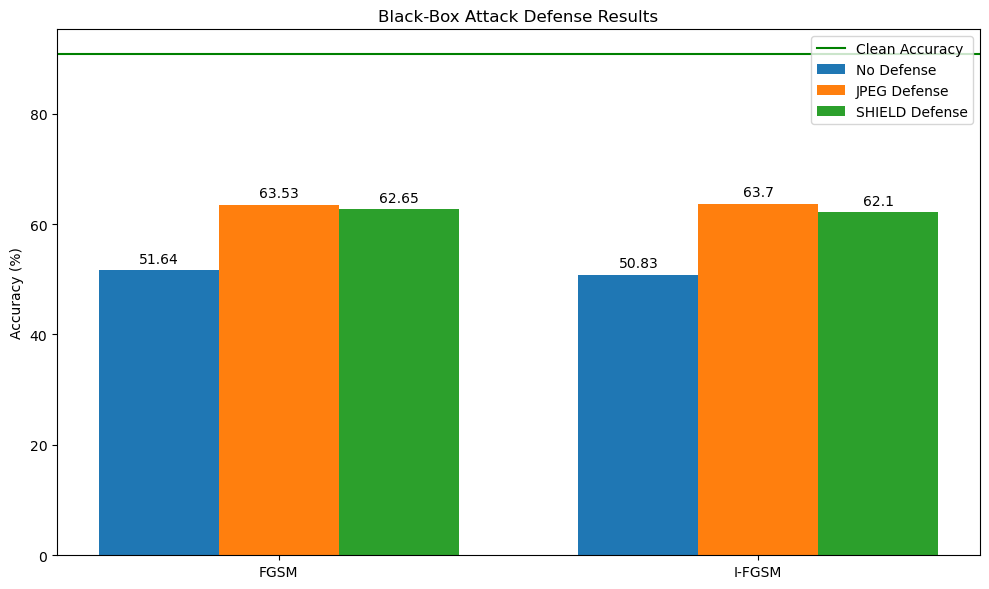

{'clean': 90.73,
 'fgsm': 51.64,
 'ifgsm': 50.83,
 'fgsm_jpeg': 63.53,
 'ifgsm_jpeg': 63.7,
 'fgsm_slq': 62.65,
 'ifgsm_slq': 62.1}

In [12]:
run_black_box_experiment(data_dir, qualities, batch_size)

In [23]:
def add_random_noise(images, noise_level=0.01):
    """
    Add random Gaussian noise to images.
    
    Args:
        images: Tensor of shape [batch_size, channels, height, width]
        noise_level: Standard deviation of the noise (relative to image range)
    
    Returns:
        Noisy images as tensor
    """
    # Generate random noise with same shape as input
    noise = torch.randn_like(images) * noise_level
    
    # Add noise to images
    noisy_images = images + noise
    
    # Clamp values to valid range [0,1] if images are normalized
    if images.min() >= 0 and images.max() <= 1:
        noisy_images = torch.clamp(noisy_images, 0, 1)
    
    return noisy_images

def progressive_defense_stacking(images):
    """Defense pipeline: SLQ → Noise → JPEG80 → Ensemble"""
    # Step 1: Apply Stochastic Local Quantization
    defended = torch.stack([stochastic_local_quantization(img) for img in images])
    
    # Step 2: Add random noise
    defended = add_random_noise(defended, noise_level=0.01)
    
    # Step 3: Apply JPEG80 compression
    # Denormalize for JPEG compression
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    denormalized = defended * std + mean
    
    # Convert to numpy for JPEG compression
    defended_np = denormalized.cpu().numpy().transpose(0, 2, 3, 1)
    defended_np = (defended_np * 255).astype(np.uint8)
    
    # Apply JPEG80 compression
    jpeg_images = []
    for img in defended_np:
        compressed = jpeg_compress_np(img, 80)
        jpeg_images.append(compressed)
    
    # Convert back to tensor and normalize
    jpeg_tensors = torch.stack([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(
            torch.from_numpy(img.transpose(2, 0, 1)).float()/255.0
        ) for img in jpeg_images
    ]).to(device)
    
    return jpeg_tensors

def run_black_box_with_progressive_defense(test_dir, qualities=[60, 70, 80, 90], batch_size=16):
    """Run black-box attack experiment with progressive defense stacking"""
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset and dataloader
    test_dataset = TestImageDataset(root_dir=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Load vaccinated models
    model_list = load_vaccinated_models(qualities, num_classes=len(test_dataset.classes))
    
    # Create a different model architecture for black-box attack
    black_box_model = models.densenet121(pretrained=True)
    num_ftrs = black_box_model.classifier.in_features
    black_box_model.classifier = torch.nn.Linear(num_ftrs, len(test_dataset.classes))
    black_box_model.to(device)
    black_box_model.eval()
    
    # Define attacks using the black-box model
    fgsm_attack = torchattacks.FGSM(black_box_model, eps=8/255)
    ifgsm_attack = torchattacks.PGD(black_box_model, eps=8/255, alpha=2/255, steps=10, random_start=False)
    
    # Results collection
    results = {
        'clean': {'correct': 0, 'total': 0},
        'fgsm': {'correct': 0, 'total': 0},
        'ifgsm': {'correct': 0, 'total': 0},
        'fgsm_slq': {'correct': 0, 'total': 0},
        'ifgsm_slq': {'correct': 0, 'total': 0},
        'fgsm_progressive': {'correct': 0, 'total': 0},
        'ifgsm_progressive': {'correct': 0, 'total': 0},
    }
    
    # Evaluation loop
    count = 0
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        
        # Clean images evaluation
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch as clean images")
        clean_preds = ensemble_predict(model_list, images)
        results['clean']['correct'] += (clean_preds == labels).sum().item()
        results['clean']['total'] += batch_size
        
        # Generate adversarial examples using black-box model
        fgsm_images = fgsm_attack(images, labels)
        ifgsm_images = ifgsm_attack(images, labels)
        
        # Evaluate on adversarial examples
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch as adversarial images")        
        fgsm_preds = ensemble_predict(model_list, fgsm_images)
        ifgsm_preds = ensemble_predict(model_list, ifgsm_images)
        
        results['fgsm']['correct'] += (fgsm_preds == labels).sum().item()
        results['fgsm']['total'] += batch_size
        results['ifgsm']['correct'] += (ifgsm_preds == labels).sum().item()
        results['ifgsm']['total'] += batch_size
        
        # Apply SLQ defense
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch with SLQ defense")
        fgsm_slq = torch.stack([stochastic_local_quantization(img) for img in fgsm_images])
        ifgsm_slq = torch.stack([stochastic_local_quantization(img) for img in ifgsm_images])
        
        # Evaluate SLQ defense
        fgsm_slq_preds = ensemble_predict(model_list, fgsm_slq)
        ifgsm_slq_preds = ensemble_predict(model_list, ifgsm_slq)
        
        results['fgsm_slq']['correct'] += (fgsm_slq_preds == labels).sum().item()
        results['fgsm_slq']['total'] += batch_size
        results['ifgsm_slq']['correct'] += (ifgsm_slq_preds == labels).sum().item()
        results['ifgsm_slq']['total'] += batch_size
        
        # Apply Progressive Defense Stacking
        if count % 500 == 0 or count == 3125:
            print(f"{count} evaluating batch with Progressive Defense")
        fgsm_progressive = progressive_defense_stacking(fgsm_images)
        ifgsm_progressive = progressive_defense_stacking(ifgsm_images)
        
        # Evaluate Progressive Defense
        fgsm_progressive_preds = ensemble_predict(model_list, fgsm_progressive)
        ifgsm_progressive_preds = ensemble_predict(model_list, ifgsm_progressive)
        
        results['fgsm_progressive']['correct'] += (fgsm_progressive_preds == labels).sum().item()
        results['fgsm_progressive']['total'] += batch_size
        results['ifgsm_progressive']['correct'] += (ifgsm_progressive_preds == labels).sum().item()
        results['ifgsm_progressive']['total'] += batch_size
        
        count += 1
    
    # Calculate accuracies
    accuracies = {}
    for key in results:
        accuracies[key] = 100 * results[key]['correct'] / results[key]['total']
    
    # Print results
    print("\nBlack-Box Attack Defense Results:")
    print(f"Clean Images: {accuracies['clean']:.2f}%")
    print("\nAdversarial Images:")
    print(f"FGSM Attack: {accuracies['fgsm']:.2f}%")
    print(f"I-FGSM Attack: {accuracies['ifgsm']:.2f}%")
    print("\nSHIELD Defense (SLQ):")
    print(f"FGSM + SLQ: {accuracies['fgsm_slq']:.2f}% (Improvement: {accuracies['fgsm_slq'] - accuracies['fgsm']:.2f}%)")
    print(f"I-FGSM + SLQ: {accuracies['ifgsm_slq']:.2f}% (Improvement: {accuracies['ifgsm_slq'] - accuracies['ifgsm']:.2f}%)")
    print("\nProgressive Defense Stacking:")
    print(f"FGSM + Progressive: {accuracies['fgsm_progressive']:.2f}% (Improvement: {accuracies['fgsm_progressive'] - accuracies['fgsm']:.2f}%)")
    print(f"I-FGSM + Progressive: {accuracies['ifgsm_progressive']:.2f}% (Improvement: {accuracies['ifgsm_progressive'] - accuracies['ifgsm']:.2f}%)")
    
    # Plot results
    attacks = ['FGSM', 'I-FGSM']
    no_defense = [accuracies['fgsm'], accuracies['ifgsm']]
    slq_defense = [accuracies['fgsm_slq'], accuracies['ifgsm_slq']]
    progressive_defense = [accuracies['fgsm_progressive'], accuracies['ifgsm_progressive']]
    
    x = np.arange(len(attacks))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, no_defense, width, label='No Defense')
    rects2 = ax.bar(x, slq_defense, width, label='SLQ Defense')
    rects3 = ax.bar(x + width, progressive_defense, width, label='Progressive Defense')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Black-Box Attack Defense Results')
    ax.set_xticks(x)
    ax.set_xticklabels(attacks)
    ax.legend()
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    
    plt.axhline(y=accuracies['clean'], color='g', linestyle='-', label='Clean Accuracy')
    plt.legend(['Clean Accuracy', 'No Defense', 'SLQ Defense', 'Progressive Defense'])
    
    fig.tight_layout()
    plt.savefig('progressive_defense_results.png')
    plt.show()
    
    return accuracies


C:\Users\CSE IIT BHILAI\AppData\Local\Temp\ipykernel_14500\388274034.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'resnet50_{qualit

0 evaluating batch as clean images
0 evaluating batch as adversarial images
0 evaluating batch with SLQ defense
0 evaluating batch with Progressive Defense
500 evaluating batch as clean images
500 evaluating batch as adversarial images
500 evaluating batch with SLQ defense
500 evaluating batch with Progressive Defense

Black-Box Attack Defense Results:
Clean Images: 90.73%

Adversarial Images:
FGSM Attack: 51.56%
I-FGSM Attack: 51.05%

SHIELD Defense (SLQ):
FGSM + SLQ: 62.26% (Improvement: 10.70%)
I-FGSM + SLQ: 62.14% (Improvement: 11.09%)

Progressive Defense Stacking:
FGSM + Progressive: 39.43% (Improvement: -12.13%)
I-FGSM + Progressive: 39.56% (Improvement: -11.49%)


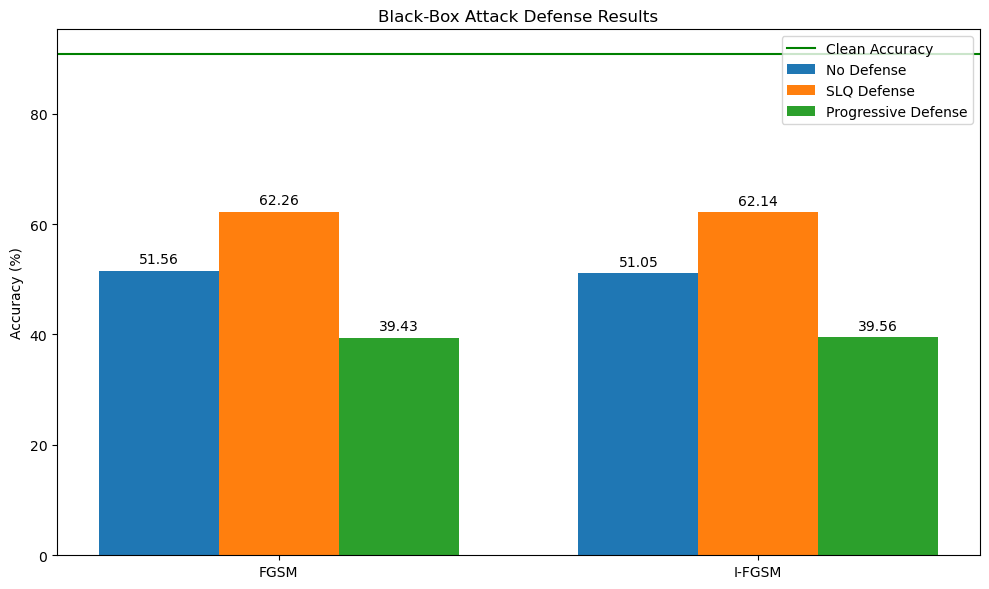

In [24]:
defense_results = run_black_box_with_progressive_defense(data_dir)


In [31]:
import torch
import torchvision
from transformers import AutoImageProcessor, AutoModel
import numpy as np
from torch.nn.functional import interpolate

def get_vit_attention_maps(image_tensor, threshold=0.5):
    """
    Extract attention maps from a Vision Transformer model.
    
    Args:
        image_tensor: Normalized image tensor [1, 3, H, W]
        threshold: Threshold for creating binary attention mask
        
    Returns:
        attention_mask: Binary mask of high-attention regions
    """
    # Load ViT model
    model_id = "facebook/dinov2-large"  # or any other ViT model
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModel.from_pretrained(model_id)
    model.eval()
    
    # Convert tensor to PIL for processor
    if image_tensor.max() <= 1.0:
        img_for_vit = (image_tensor.cpu().permute(1, 2, 0) * 255).numpy().astype(np.uint8)
    else:
        img_for_vit = image_tensor.cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    
    from PIL import Image
    pil_image = Image.fromarray(img_for_vit)
    
    # Process image for ViT
    inputs = processor(images=pil_image, return_tensors="pt")
    
    # Get attention maps
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Extract attention from last layer (focusing on CLS token)
    attention_scores = outputs.attentions[-1]
    num_heads = attention_scores.shape[1]
    
    # Get attention from CLS token to image patches
    attentions = attention_scores[0, :, 0, 1:].reshape(num_heads, -1)
    
    # Reshape to match image patches
    patch_size = 16  # Standard for ViT-base
    num_patches = int(np.sqrt(attentions.shape[1]))
    attentions = attentions.reshape(num_heads, num_patches, num_patches)
    
    # Average across heads
    avg_attention = torch.mean(attentions, dim=0)
    
    # Resize to match input image size
    h, w = image_tensor.shape[-2:]
    attention_map = interpolate(avg_attention.unsqueeze(0).unsqueeze(0), 
                               size=(h, w), 
                               mode='bilinear').squeeze()
    
    # Normalize attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Create binary mask of high-attention regions
    attention_mask = (attention_map > threshold).float()
    
    return attention_mask

def attention_guided_compression(image, attention_mask, high_quality=80, low_quality=30):
    """
    Apply different JPEG compression levels based on attention map.
    
    Args:
        image: Input image (numpy array or tensor)
        attention_mask: Binary mask of high-attention regions
        high_quality: JPEG quality for high-attention regions
        low_quality: JPEG quality for low-attention regions
        
    Returns:
        Compressed image with attention-guided quality levels
    """
    # Convert image to numpy if it's a tensor
    if isinstance(image, torch.Tensor):
        if image.is_cuda:
            image = image.cpu()
        
        # Denormalize if needed
        if image.max() <= 1.0:
            image = image * 255
            
        image = image.permute(1, 2, 0).numpy().astype(np.uint8)
    elif isinstance(image, Image.Image):
        image = np.array(image)
    
    # Create empty array for result
    result = np.zeros_like(image)
    
    # Convert attention mask to numpy if needed
    if isinstance(attention_mask, torch.Tensor):
        attention_mask = attention_mask.cpu().numpy()
    
    # Create binary mask
    mask = attention_mask > 0.5
    
    # Apply high quality compression to important regions
    important_regions = image.copy()
    important_regions[~mask] = 0  # Zero out non-important regions
    compressed_important = jpeg_compress_np(important_regions, high_quality)
    
    # Apply low quality compression to background regions
    background_regions = image.copy()
    background_regions[mask] = 0  # Zero out important regions
    compressed_background = jpeg_compress_np(background_regions, low_quality)
    
    # Combine the two compressed images
    result = compressed_important + compressed_background
    
    return result

def process_with_attention_guided_compression(images, high_quality=80, low_quality=30):
    """
    Process a batch of images with attention-guided compression.
    
    Args:
        images: Batch of images (tensor)
        high_quality: JPEG quality for high-attention regions
        low_quality: JPEG quality for low-attention regions
        
    Returns:
        Batch of compressed images
    """
    processed_images = []
    
    for img in images:
        # Get attention map
        attention_mask = get_vit_attention_maps(img)
        
        # Apply attention-guided compression
        compressed_img = attention_guided_compression(
            img, 
            attention_mask, 
            high_quality=high_quality, 
            low_quality=low_quality
        )
        
        # Convert back to tensor and normalize
        if isinstance(compressed_img, np.ndarray):
            compressed_img = torch.from_numpy(compressed_img).permute(2, 0, 1).float() / 255.0
            
            # Normalize
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            compressed_img = normalize(compressed_img)
        
        processed_images.append(compressed_img)
    
    # Stack back into batch
    return torch.stack(processed_images).to(device)

# Usage in defense evaluation
def run_attention_guided_defense_experiment(test_dir, qualities=[60, 70, 80, 90], batch_size=16):
    # Similar to previous experiments, but using attention-guided compression
# Define transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset and dataloader
    test_dataset = TestImageDataset(root_dir=test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Load vaccinated models
    model_list = load_vaccinated_models(qualities, num_classes=len(test_dataset.classes))
    
    # Create a different model architecture for black-box attack
    black_box_model = models.densenet121(pretrained=True)
    num_ftrs = black_box_model.classifier.in_features
    black_box_model.classifier = torch.nn.Linear(num_ftrs, len(test_dataset.classes))
    black_box_model.to(device)
    black_box_model.eval()
    
    # Define attacks using the black-box model
    fgsm_attack = torchattacks.FGSM(black_box_model, eps=8/255)
    ifgsm_attack = torchattacks.PGD(black_box_model, eps=8/255, alpha=2/255, steps=10, random_start=False)
    # Load models, create dataset, etc.
    
    # Results collection
    results = {
        'clean': {'correct': 0, 'total': 0},
        'fgsm': {'correct': 0, 'total': 0},
        'ifgsm': {'correct': 0, 'total': 0},
        'fgsm_attention': {'correct': 0, 'total': 0},
        'ifgsm_attention': {'correct': 0, 'total': 0},
    }
    
    # Evaluation loop
    for images, labels, _ in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        
        # Generate adversarial examples
        fgsm_images = fgsm_attack(images, labels)
        ifgsm_images = ifgsm_attack(images, labels)
        
        # Apply attention-guided compression defense
        fgsm_defended = process_with_attention_guided_compression(fgsm_images)
        ifgsm_defended = process_with_attention_guided_compression(ifgsm_images)
        
        # Evaluate
        fgsm_defended_preds = ensemble_predict(model_list, fgsm_defended)
        ifgsm_defended_preds = ensemble_predict(model_list, ifgsm_defended)
        
        results['fgsm_attention']['correct'] += (fgsm_defended_preds == labels).sum().item()
        results['fgsm_attention']['total'] += batch_size
        results['ifgsm_attention']['correct'] += (ifgsm_defended_preds == labels).sum().item()
        results['ifgsm_attention']['total'] += batch_size
        
    # Calculate and print results

    
    return results


In [32]:
defense_results_new = run_attention_guided_defense_experiment(data_dir)

C:\Users\CSE IIT BHILAI\AppData\Local\Temp\ipykernel_14500\388274034.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'resnet50_{qualit

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

C:\Users\CSE IIT BHILAI\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\CSE IIT BHILAI\.cache\huggingface\hub\models--facebook--dinov2-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Using a slow image processor as `use_fast` is unset and a slow processor was saved wi

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [2]:
# Calculate and print results
accuracies = {}
print(defense_results_new)
for key in defense_results_new:
    accuracies[key] = 100 * defense_results_new[key]['correct'] / defense_results_new[key]['total']

{'clean': {'correct': 9073, 'total': 10000}, 'fgsm': {'correct': 5163, 'total': 10000}, 'ifgsm': {'correct': 5117, 'total': 10000}, 'fgsm_attention': {'correct': 6336, 'total': 10000}, 'ifgsm_attention': {'correct': 6417, 'total': 10000}}


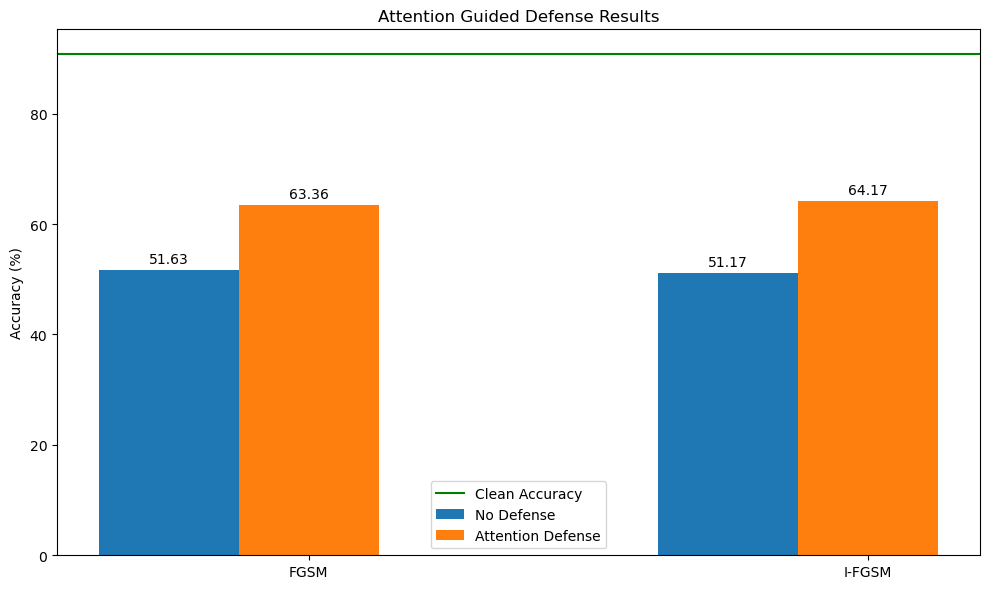

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Plot results
attacks = ['FGSM', 'I-FGSM']
no_defense = [accuracies['fgsm'], accuracies['ifgsm']]
slq_defense = [accuracies['fgsm_attention'], accuracies['ifgsm_attention']]
    
x = np.arange(len(attacks))
width = 0.25
    
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, no_defense, width, label='No Defense')
rects2 = ax.bar(x, slq_defense, width, label='SLQ Defense')
    
ax.set_ylabel('Accuracy (%)')
ax.set_title('Attention Guided Defense Results')
ax.set_xticks(x)
ax.set_xticklabels(attacks)
ax.legend()
    
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
    
plt.axhline(y=accuracies['clean'], color='g', linestyle='-', label='Clean Accuracy')
plt.legend(['Clean Accuracy', 'No Defense', 'Attention Defense'])
    
fig.tight_layout()
plt.savefig('attention_results.png')
plt.show()